In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [71]:
# Read in dataset and examine its attributes
fer_df = pd.read_csv('fer2013/fer2013.csv')
fer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [72]:
# Drop the usage column because we don't need it
fer_df.drop(['Usage'], axis=1, inplace=True)

In [73]:
# Map the emotion integer encoding to labels 
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


emotion
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: count, dtype: int64

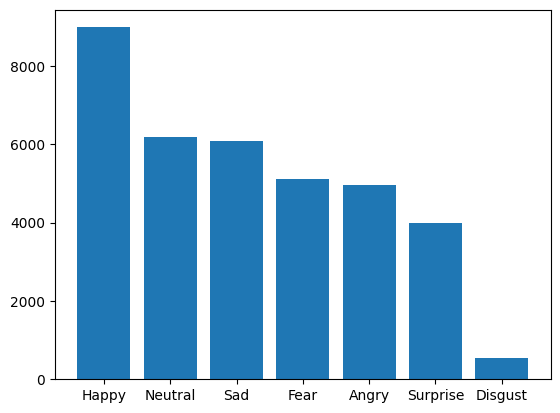

In [74]:
# Examine distribution of emotion class labels
emotion_counts = fer_df['emotion'].value_counts()
emotion_counts = emotion_counts.rename(lambda x: emotion_mapping[x])

display(emotion_counts)

plt.bar(emotion_counts.index, emotion_counts.values)
plt.show()

In [75]:
print(type(fer_df['pixels'].iloc[0]))

<class 'str'>


In [76]:
# Convert pixel strings to numpy arrays, reshape, and normalize
fer_df['pixels'] = fer_df['pixels'].apply(lambda img: np.array(img.split(' ')).reshape(48, 48).astype('float32')/255.0)
print(fer_df['pixels'].iloc[0].shape)

(48, 48)


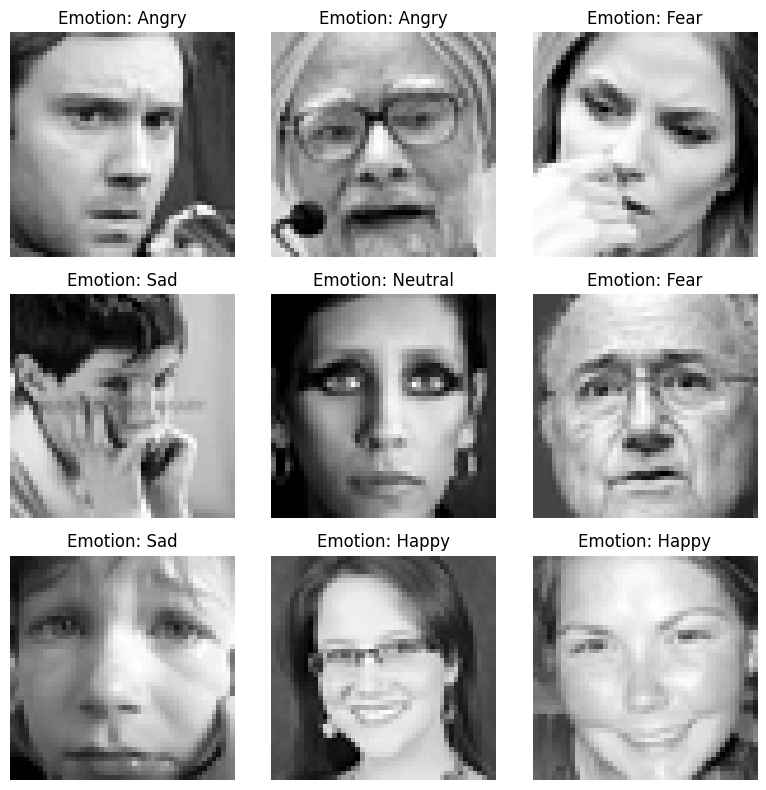

In [77]:
# Display the first few images in grayscale
fig = plt.figure(figsize=(8,8))
for i in range(9):
    img = fer_df['pixels'].iloc[i]
    emotion = emotion_mapping[fer_df['emotion'].iloc[i]]
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Emotion: {emotion}")
    plt.axis('off')

fig.tight_layout()
plt.show()

New shape: (192, 192)


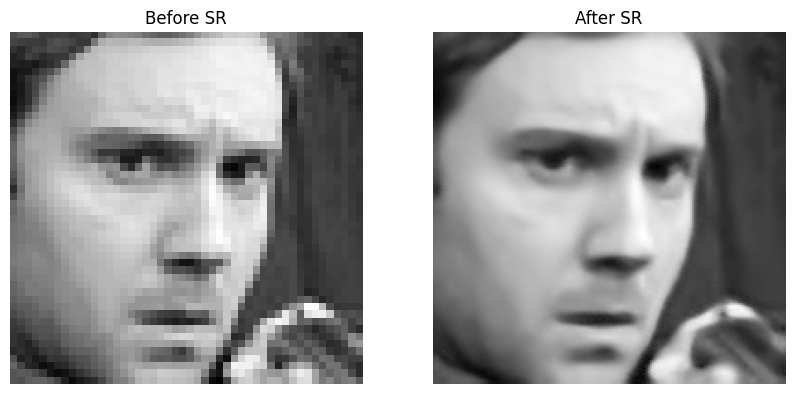

In [80]:
# Use super-resolution to make the images higher resolution
sr = cv2.dnn_superres.DnnSuperResImpl_create()
scale = 4
path = f'models/LapSRN_x{scale}.pb'
sr.readModel(path)
sr.setModel('lapsrn', scale)

def improve_resolution(img):
    # Convert image to be 8-bit
    image_uint8 = (img * 255).astype('uint8')

    # Use the model to upsample the image
    result = sr.upsample(image_uint8)

    # Normalize the output again
    result_normalized = result.astype('float32') / 255.0
    return result_normalized

# Test on one sample
sample_image = fer_df['pixels'].iloc[0]
sr_image = improve_resolution(sample_image)
print(f"New shape: {sr_image.shape}")

fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Before SR")
plt.imshow(sample_image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After SR")
plt.imshow(sr_image, cmap='gray')
plt.axis('off')
plt.show()


In [81]:
# Apply to all images
fer_df['pixels'] = fer_df['pixels'].apply(improve_resolution)

# Check that it worked
plt.imshow(fer_df['pixels'].iloc[0], cmap='gray')
plt.show()

In [ ]:
# Convert dataframe to tensorflow dataset
images = np.stack(fer_df['pixels'].values)
labels = fer_df['emotion'].values

fer_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
fer_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

(48, 48, 1)


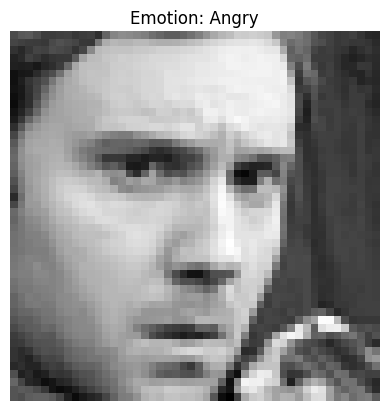

In [ ]:
# Check that conversion worked
for img, label in fer_dataset.take(1):
    print(img.shape)
    plt.title(f"Emotion: {emotion_mapping[label.numpy()]}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
print(fer_dataset)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
